1/1 [==============================] - 1s 639ms/step


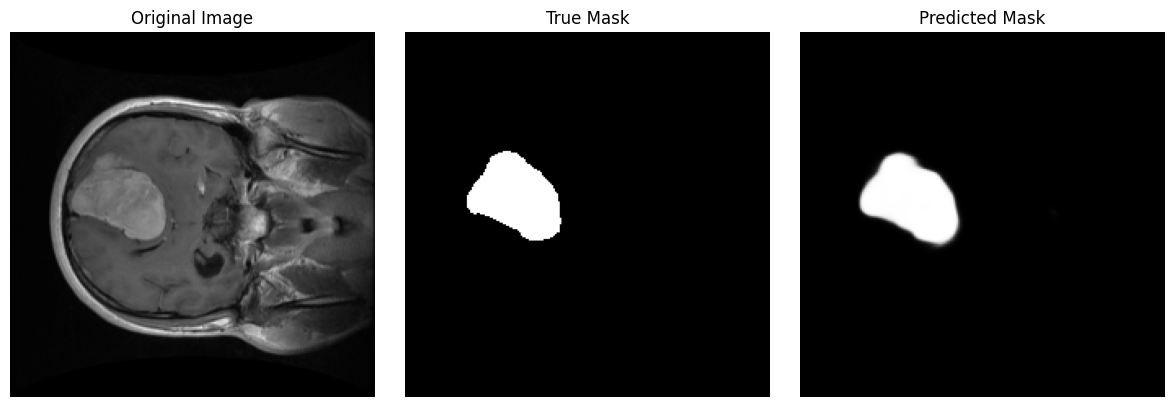

In [1]:
import os
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define the dice coefficient for model evaluation
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

# Load the model once and reuse it
model_path = 'non_fold_unet.h5'
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

def load_and_preprocess_image(file_path, image_size=(224, 224)):
    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == ".mat":
        with h5py.File(file_path, 'r') as f:
            image_data = np.array(f['cjdata']['image'])
            try:
                mask_data = np.array(f['cjdata']['tumorMask'])
            except KeyError:
                mask_data = None

    else:
        image_data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        # Create a blank mask of zeros with the same dimensions as the image
        mask_data = np.zeros_like(image_data)

    if mask_data is not None:
        mask = cv2.resize(mask_data, image_size, interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)
    else:
        mask = None

    image = cv2.resize(image_data, image_size, interpolation=cv2.INTER_AREA)
    image = np.expand_dims(image, axis=-1) / 255.0

    return image, mask

def display_results(image, true_mask, predicted_mask):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    if true_mask is not None:
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('True Mask')
    else:
        plt.title('No True Mask Available')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def make_prediction(image):
    image_batch = np.expand_dims(image, axis=0)  # Expand dimensions for batch input
    return model.predict(image_batch)


file_path = r"C:\Users\omarb\OneDrive\Desktop\Random Brain Images\302.mat"  # Path to the Brain MRI

# Process the image
image, true_mask = load_and_preprocess_image(file_path)

# Predict the mask
predicted_mask = make_prediction(image)

# Display results
display_results(image, true_mask, predicted_mask)
